In [2]:
import time
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt

from utils.hmatr import Hmatr
from utils.modelling import modelling

import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr

import openpyxl
import pandas as pd

%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

utils.install_packages('Rssa')

# library(Rssa)
rssa = importr('Rssa')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



# Инициализация

In [3]:
N = 700
w1 = 1/10
w2 = 1/5
C1 = 1
C2 = 2
phi1 = 0
phi2 = np.pi/2
Q = 301  # 301 номер, значит разладка в ряде будет на 302й точке, если ряд задан с 0.
B = 100
T_ = 100
L = 50
r = 2

method = "svd"

In [4]:
def plotSeries(s, title='Series', w=16, h=4):
    plt.figure(figsize=(w, h))
    plt.title(title)
    plt.plot(s)

## Данные

Генерируем данные с фиксированным шумом и без.

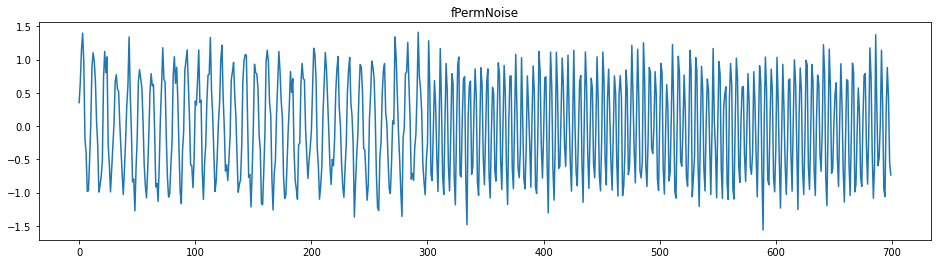

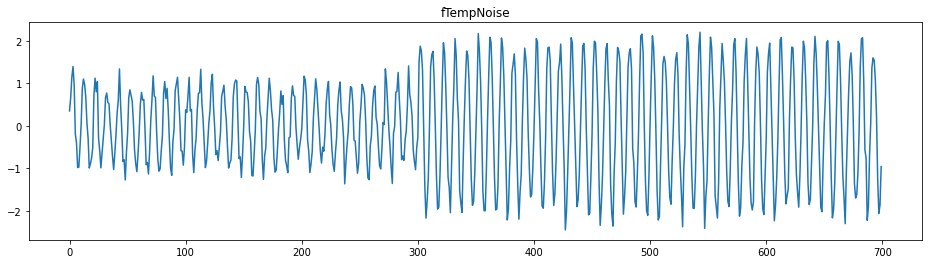

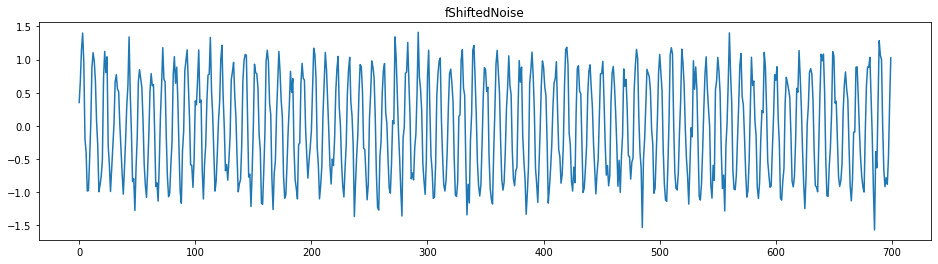

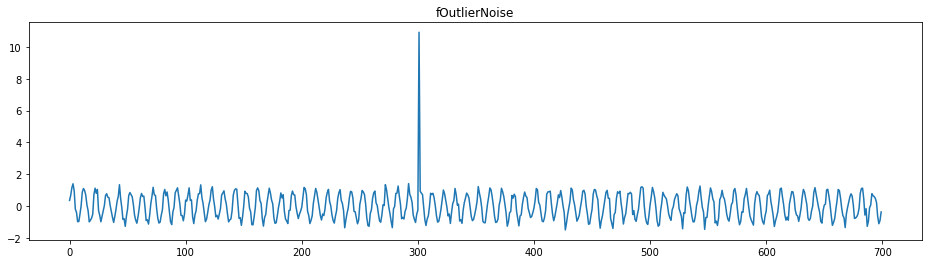

In [6]:
seriesPermanent = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w2*n + phi1)
seriesTemporary = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C2*np.sin(2*np.pi*w1*n + phi1)
seriesShifted = lambda n: C1*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C1*np.sin(2*np.pi*w1*n + phi2)
seriesOutlier = lambda n: C1*np.sin(2*np.pi*w1*n + phi1)

np.random.seed(0)
eps = np.random.randn(N) * 0.2

fPerm = [seriesPermanent(i) for i in range(N)]
fPermNoise = fPerm + eps
hmPerm = Hmatr(fPerm, B, T_, L, neig=r, svdMethod=method)
hmPermNoise = Hmatr(fPermNoise, B, T_, L, neig=r, svdMethod=method)

fTemp = [seriesTemporary(i) for i in range(N)]
fTempNoise = fTemp + eps
hmTemp = Hmatr(fTemp, B, T_, L, neig=r, svdMethod=method)
hmTempNoise = Hmatr(fTempNoise, B, T_, L, neig=r, svdMethod=method)

fShifted = [seriesShifted(i) for i in range(N)]
fShiftedNoise = fShifted + eps
hmShifted = Hmatr(fShifted, B, T_, L, neig=r, svdMethod=method)
hmShiftedNoise = Hmatr(fShiftedNoise, B, T_, L, neig=r, svdMethod=method)


fOutlier = [seriesOutlier(i) for i in range(N)]
fOutlier[Q] = fOutlier[Q] + 10
fOutlierNoise = fOutlier + eps
hmOutlier = Hmatr(fOutlier, B, T_, L, neig=r, svdMethod=method)
hmOutlierNoise = Hmatr(fOutlierNoise, B, T_, L, neig=r, svdMethod=method)

plotSeries(fPermNoise, 'fPermNoise')
plotSeries(fTempNoise, 'fTempNoise')
plotSeries(fShiftedNoise, 'fShiftedNoise')
plotSeries(fOutlierNoise, 'fOutlierNoise')

Посмотрим на функции разладки

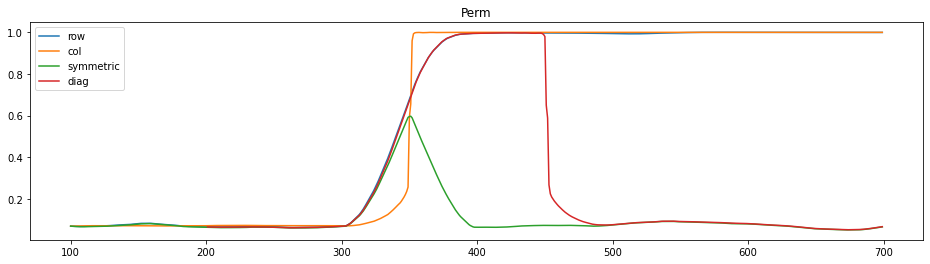

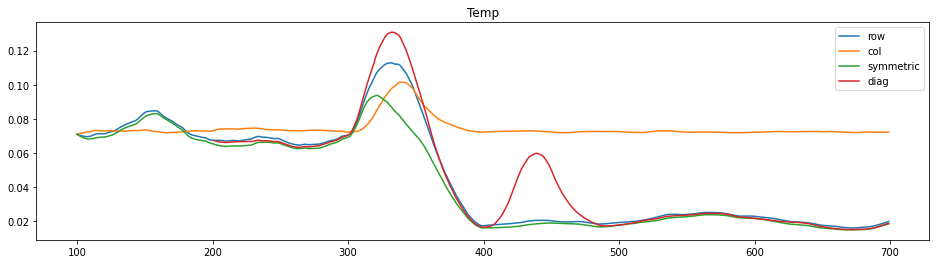

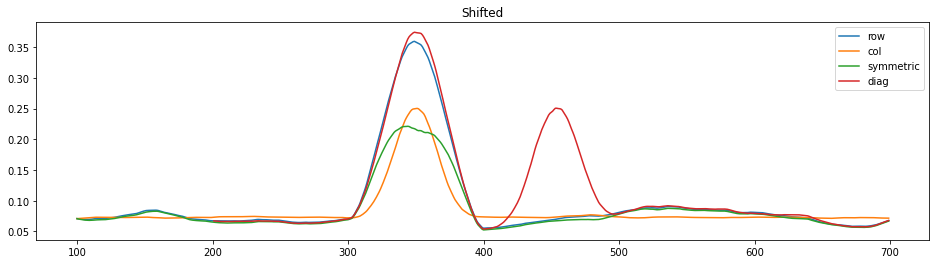

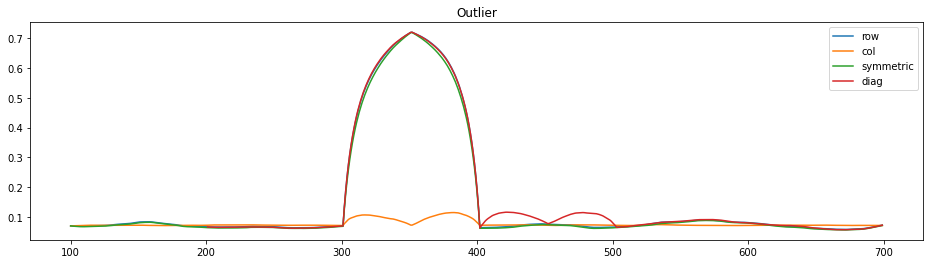

In [7]:
hmPermNoise.plotHeterFunc('Perm')
hmTempNoise.plotHeterFunc('Temp')
hmShiftedNoise.plotHeterFunc('Shifted')
hmOutlierNoise.plotHeterFunc('Outlier')

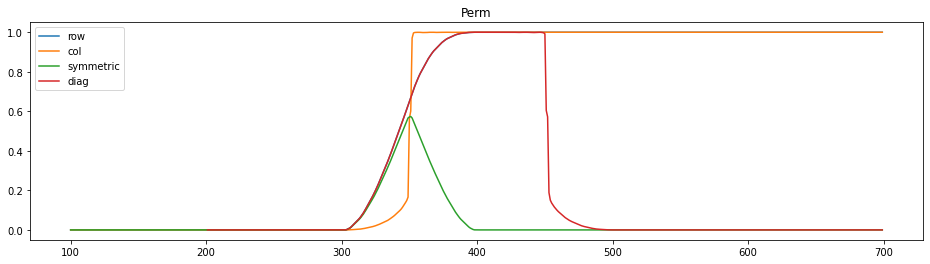

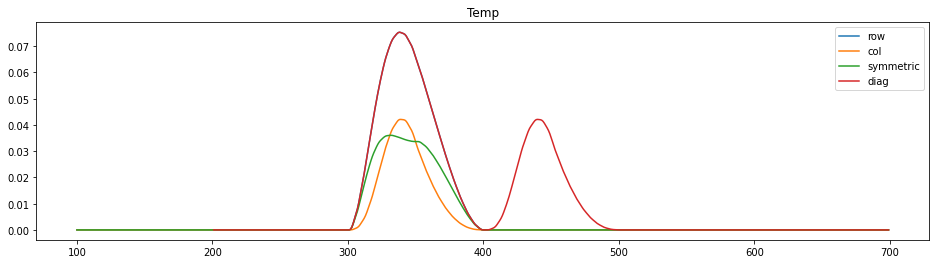

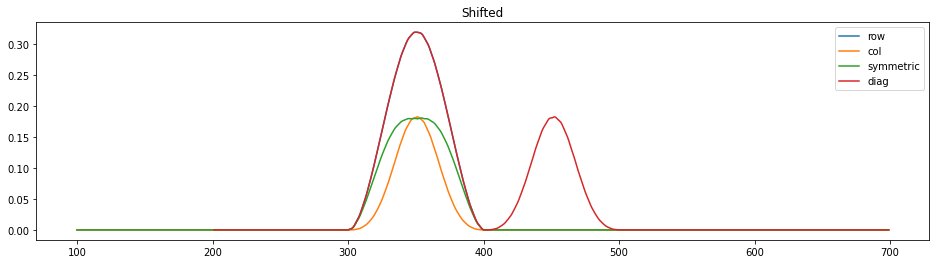

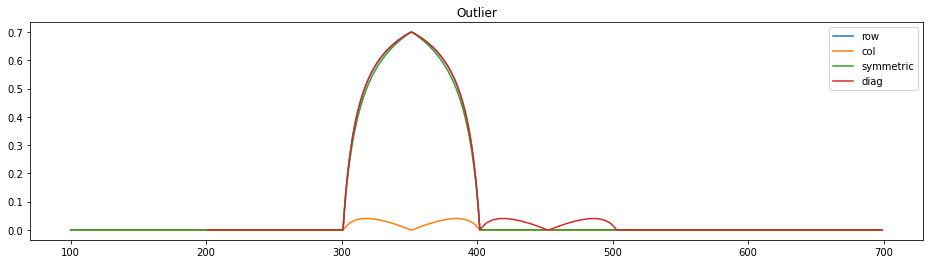

In [8]:
hmPerm.plotHeterFunc('Perm')
hmTemp.plotHeterFunc('Temp')
hmShifted.plotHeterFunc('Shifted')
hmOutlier.plotHeterFunc('Outlier')

**Стоит заранее отметить, что какие-либо дальнейшие тесты для случаев с временной разладкой и фазовым сдвигом не имеют смысла** - сила исследуемого шума слишком велика для каких-либо разговоров об обнаружении.  

# Моделирование

Смоделируем случайный шум с дисперсией `0.25` `200` раз на отрезке $[0, \cdots, Q-1]$ и посчитаем характеристики:
* Средний максимум;
* Средний 95 процентиль.

**Внимание**, моделирование достаточно долгое. На процессоре `Intel Core i5-7300HQ` моделирование на `200` итерациях `4`х вариантов, определенных выше заняло `30` минут.

In [9]:
?modelling

Signature:
modelling(
    dictSeries: dict,
    iterNum: int,
    N: int,
    B: int,
    T: int,
    Q: int,
    L: int,
    r: int,
    method: str,
    destFile: str,
)
Docstring:
:param dict dictSeries: The dictionary where key is the type of series and value is a series. Example: { 'Permanent': [x_1, ..., x_N] }.
:param int iterNum: Number of iterations for modelling.
:param int N: The len of series.
:param int B: The len of base subseries.
:param int T: The len of test subseries.
:param int Q: The point of perturbation.
:param int L: The window len.
:param int r: Number of eigen vectors.
:param str method: SVD method.
:param str destFile: Name of the file for saving results.
File:      f:\users\ivank\documents\education\magistracy\researchwork\codetest\utils\modelling.py
Type:      function


In [36]:
%%time
modelling(
    dictSeries=dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [fPermNoise, fTempNoise, fShiftedNoise, fOutlierNoise])),
    iterNum=200,
    N=N,
    B=B,
    T=T_,
    Q=Q,
    L=L,
    r=r,
    method=method,
    destFile='tables/results.xlsx'
)

Wall time: 29min 36s


## Результаты моделирования

In [11]:
resModelling = pd.read_excel('tables/results.xlsx', sheet_name='Modelling', engine='openpyxl')
resModelling.fillna(' ', inplace=True)
resModelling

,Permanent,row,col,sym,diag
0,meanMax,0.59059,0.52587,0.577664,0.556603
1,95 procentile,0.583354,0.523551,0.569541,0.553708
2,,,,,
3,Temporary,row,col,sym,diag
4,meanMax,0.583215,0.526728,0.570537,0.549614
5,95 procentile,0.57591,0.524479,0.562019,0.546216
6,,,,,
7,Shifted,row,col,sym,diag
8,meanMax,0.587149,0.523584,0.574187,0.549744
9,95 procentile,0.580319,0.521282,0.566696,0.545878


# Оценка скорости возрастания функций разладки

## По графикам с дифференцированиям

Оценим скорость возрастания с помощью дифференцирования подряда с точки $Q$. 

In [12]:
def applyDifferentiation(ser, Q, tail):
    newSer = []
    for i in range(Q-tail, len(ser)-1):
        newSer.append(ser[i+1] - ser[i])
    return newSer

### Данные с шумом

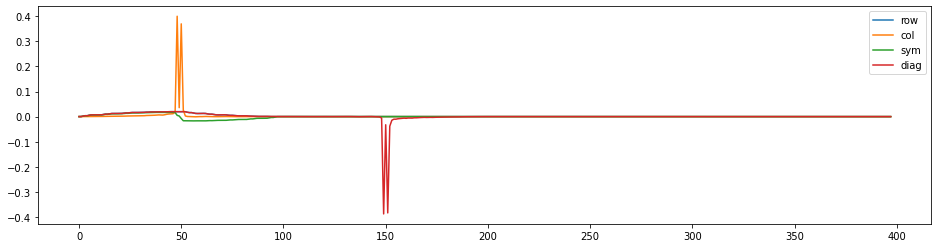

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(applyDifferentiation(hmPerm.getRow(), Q, hmPerm.T), label='row')
plt.plot(applyDifferentiation(hmPerm.getCol(), Q, hmPerm.B), label='col')
plt.plot(applyDifferentiation(hmPerm.getSym(), Q, hmPerm.T), label='sym')
plt.plot(applyDifferentiation(hmPerm.getDiag(), Q, hmPerm.B + hmPerm.T + 1), label='diag')
plt.legend()
plt.show()

Из графика видно, что хоть и с некоторой задержкой относительно остальных, но **столбцовая** функция разладки возрастает быстрее и сильнее.

# Оценка момента возрастания функций разладки

В данной серии экспериментов мы предполагаем что точка разладки известна. Тестирование каких-либо преодолений начинается с точки $Q$ (или с $Q+1$ элемента).

In [14]:
from utils.fixResultsForHeterFuncs import fixResults

R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



Начнем с тестирования на данных без шума

In [15]:
fixResults(
    dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [hmPerm, hmTemp, hmShifted, hmOutlier])),
    Q,
    'tables/results.xlsx',
    'tables/results.xlsx',
    'withoutNoise'
)

С шумом

In [16]:
fixResults(
    dict(zip(['Permanent', 'Temporary', 'Shifted', 'Outlier'], [hmPermNoise, hmTempNoise, hmShiftedNoise, hmOutlierNoise])),
    Q,
    'tables/results.xlsx',
    'tables/results.xlsx',
    'withNoise'
)

In [17]:
fixedResult = pd.read_excel('tables/results.xlsx', sheet_name='withoutNoise', engine='openpyxl')
fixedResult.fillna(' ', inplace=True)
fixedResult[:35]

,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,Row,meanMax,95 procentile,,Col,meanMax,95 procentile,,Sym,meanMax,95 procentile,,Diag,meanMax,95 procentile
1,Point of overcoming,347,347,,Point of overcoming,350,350,,Point of overcoming,,350,,Point of overcoming,346,346
2,X[point],1,1,,X[point],1,1,,X[point],,0,,X[point],0,0
3,X[point+10],1,1,,X[point+10],1,1,,X[point+10],,0,,X[point+10],0,0
4,X[point+20],1,1,,X[point+20],1,1,,X[point+20],,0,,X[point+20],0,0
5,X[point+30],1,1,,X[point+30],1,1,,X[point+30],,0,,X[point+30],0,0
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,Temporary,,,,,,,,,,,,,,
9,Row,meanMax,95 procentile,,Col,meanMax,95 procentile,,Sym,meanMax,95 procentile,,Diag,meanMax,95 procentile


Видим в таблице что-то странное. Такие результаты получились из за смещения среднего значения функций разладки на промежутке $[0, \cdots, Q]$ из-за шума.

Посмотрим на результаты данных с шумом (на которых и проводилось моделирование).

In [18]:
fixedResultNoise = pd.read_excel('tables/results.xlsx', sheet_name='withNoise', engine='openpyxl')
fixedResultNoise.fillna(' ', inplace=True)
fixedResultNoise[:35]

,Permanent,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,Row,meanMax,95 procentile,,Col,meanMax,95 procentile,,Sym,meanMax,95 procentile,,Diag,meanMax,95 procentile
1,Point of overcoming,346,345,,Point of overcoming,350,350,,Point of overcoming,349,348,,Point of overcoming,344,344
2,X[point],0.995737,0.995792,,X[point],0.998893,0.998893,,X[point],0.074566,0.074554,,X[point],0.094736,0.094736
3,X[point+10],0.995778,0.995802,,X[point+10],0.998865,0.998865,,X[point+10],0.074024,0.073891,,X[point+10],0.092188,0.092188
4,X[point+20],0.995599,0.995619,,X[point+20],0.998872,0.998872,,X[point+20],0.074663,0.074609,,X[point+20],0.090631,0.090631
5,X[point+30],0.994984,0.995112,,X[point+30],0.998864,0.998864,,X[point+30],0.073051,0.073428,,X[point+30],0.088632,0.088632
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,Temporary,,,,,,,,,,,,,,
9,Row,meanMax,95 procentile,,Col,meanMax,95 procentile,,Sym,meanMax,95 procentile,,Diag,meanMax,95 procentile


Как мы отмечали ранее, для фазового сдвига и временной разладки результаты не несут какой-либо ценности.

В остальных же случаях можно наблюдать какая функция разладки начинает возрастать раньше и по выведенным $4$ точкам можно сравнить скорость возрастания. 

Блоки с пустыми полями соответствуют ситуации, когда разладка не найдена.